In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Set plot style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. DATA LOADING AND INITIAL EXPLORATION

In [7]:
filepath="student_habits_performance.csv"
df = pd.read_csv(filepath)
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [5]:
df.shape

(1000, 16)

## 2. DATA CLEANING

In [9]:
# Check missing values
print("Missing values:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

Missing values:
parental_education_level    91
dtype: int64


In [10]:
if 'parental_education_level' in df.columns:
    missing_count = df['parental_education_level'].isnull().sum()
    if missing_count > 0:
        mode_education = df['parental_education_level'].mode()[0]
        df['parental_education_level'].fillna(mode_education, inplace=True)
        print(f"Filled {missing_count} missing parental_education_level values with mode: {mode_education}")

Filled 91 missing parental_education_level values with mode: High School


In [11]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"Duplicates: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed")

Duplicates: 0


In [12]:
# Remove student_id as it's not predictive
if 'student_id' in df.columns:
    df = df.drop('student_id', axis=1)
    print("Removed student_id column")

Removed student_id column


In [13]:
print(f"Clean dataset shape: {df.shape}")

Clean dataset shape: (1000, 15)


## 3. EXPLORATORY DATA ANALYSIS

In [15]:
# Identify column types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'exam_score']
Categorical columns: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [16]:
# Target variable analysis
print("\nTarget variable (exam_score) analysis:")
print(f"Mean: {df['exam_score'].mean():.2f}")
print(f"Std: {df['exam_score'].std():.2f}")
print(f"Min: {df['exam_score'].min():.2f}")
print(f"Max: {df['exam_score'].max():.2f}")


Target variable (exam_score) analysis:
Mean: 69.60
Std: 16.89
Min: 18.40
Max: 100.00


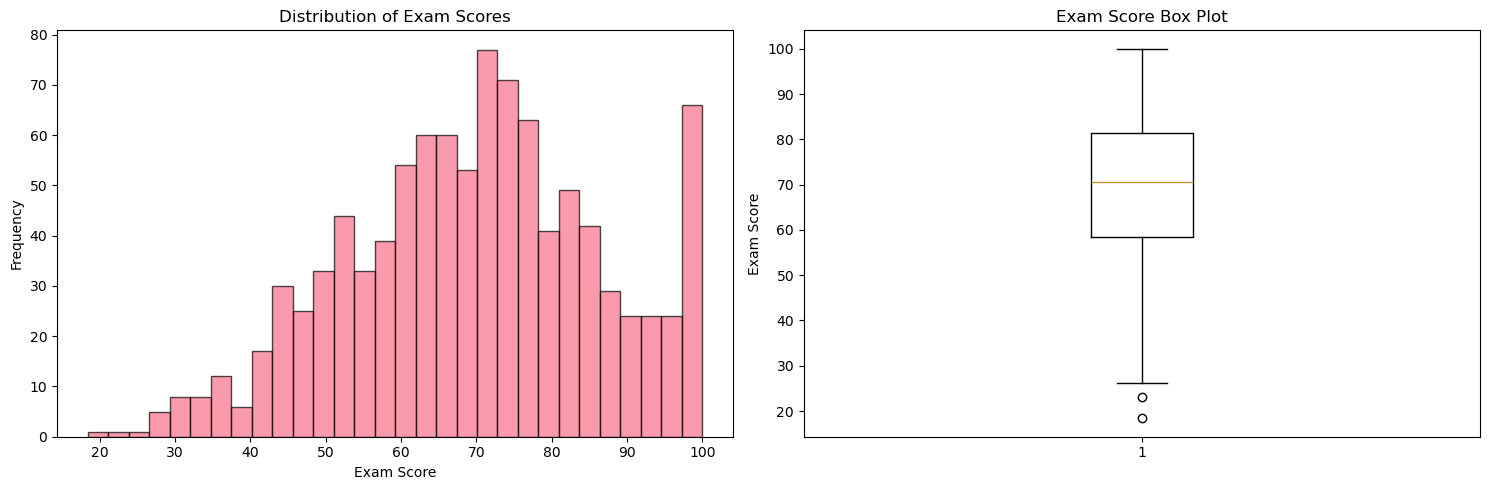

In [17]:
# Target distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(df['exam_score'], bins=30, edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Exam Scores')
ax1.set_xlabel('Exam Score')
ax1.set_ylabel('Frequency')

ax2.boxplot(df['exam_score'])
ax2.set_title('Exam Score Box Plot')
ax2.set_ylabel('Exam Score')
plt.tight_layout()
plt.show()


Categorical variable distributions:

gender:
gender
Female    481
Male      477
Other      42
Name: count, dtype: int64


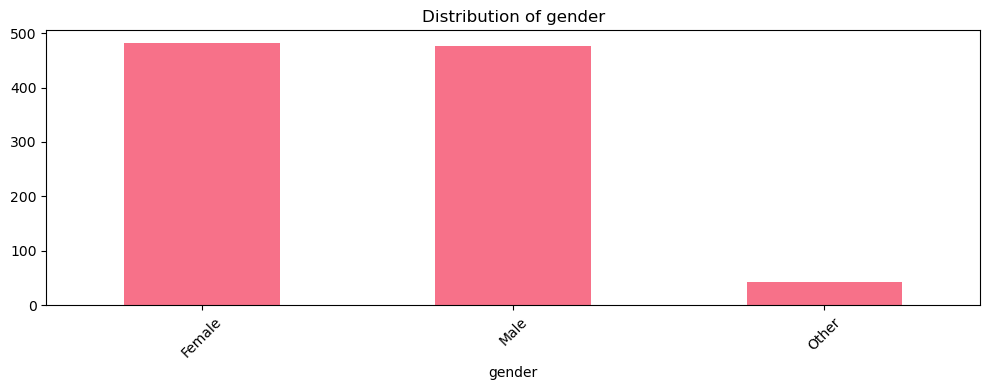


part_time_job:
part_time_job
No     785
Yes    215
Name: count, dtype: int64


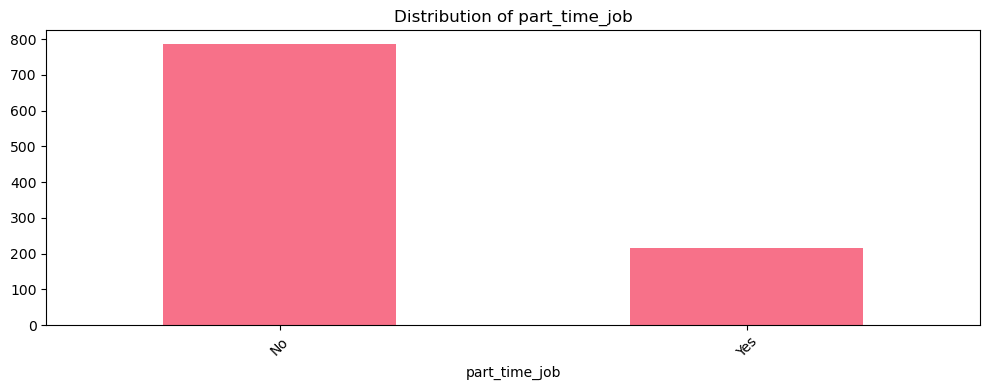


diet_quality:
diet_quality
Fair    437
Good    378
Poor    185
Name: count, dtype: int64


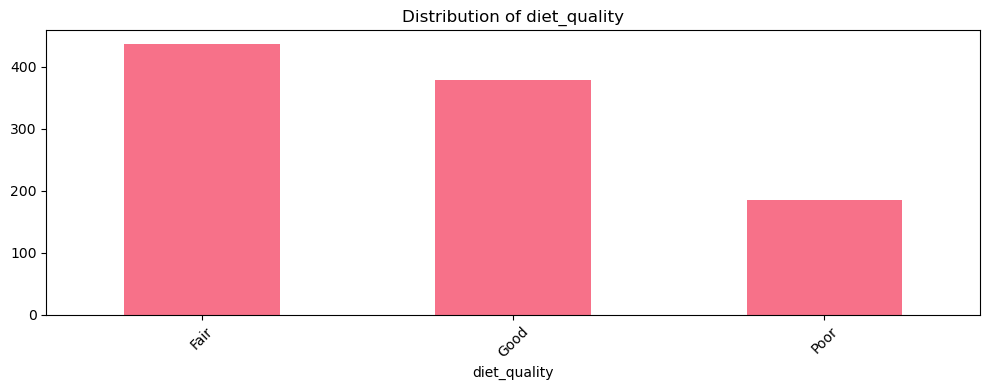


parental_education_level:
parental_education_level
High School    483
Bachelor       350
Master         167
Name: count, dtype: int64


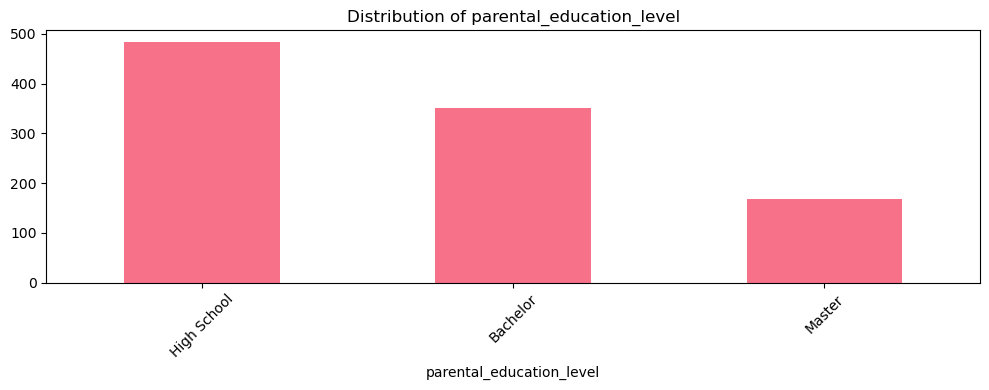


internet_quality:
internet_quality
Good       447
Average    391
Poor       162
Name: count, dtype: int64


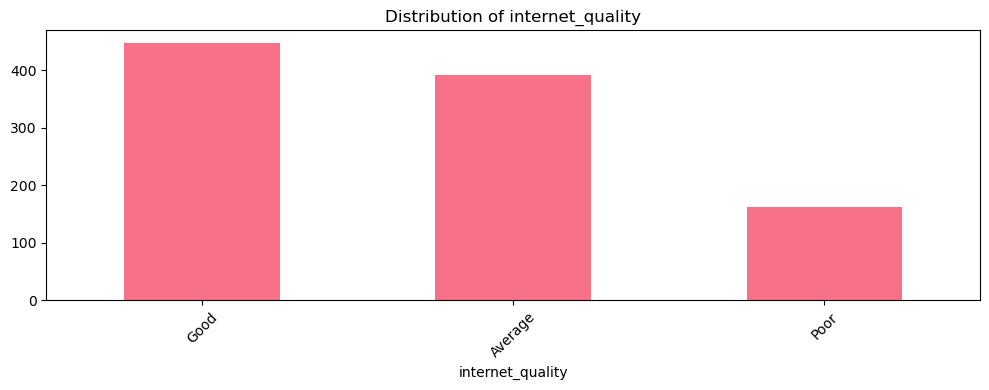


extracurricular_participation:
extracurricular_participation
No     682
Yes    318
Name: count, dtype: int64


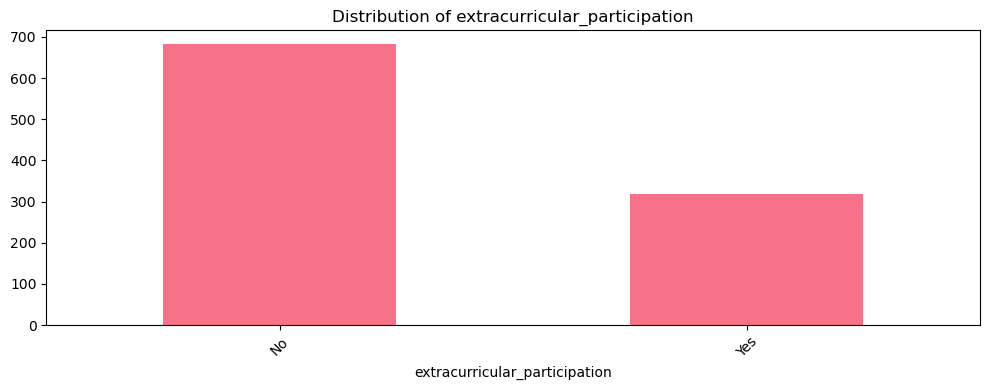

In [18]:
# Categorical variable distributions 
print("\nCategorical variable distributions:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
# Correlation analysis
print("\nCorrelation with exam_score:")
correlations = df.select_dtypes(include=[np.number]).corr()['exam_score'].sort_values(ascending=False)
print(correlations)


Correlation with exam_score:
exam_score               1.000000
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
age                     -0.008907
social_media_hours      -0.166733
netflix_hours           -0.171779
Name: exam_score, dtype: float64


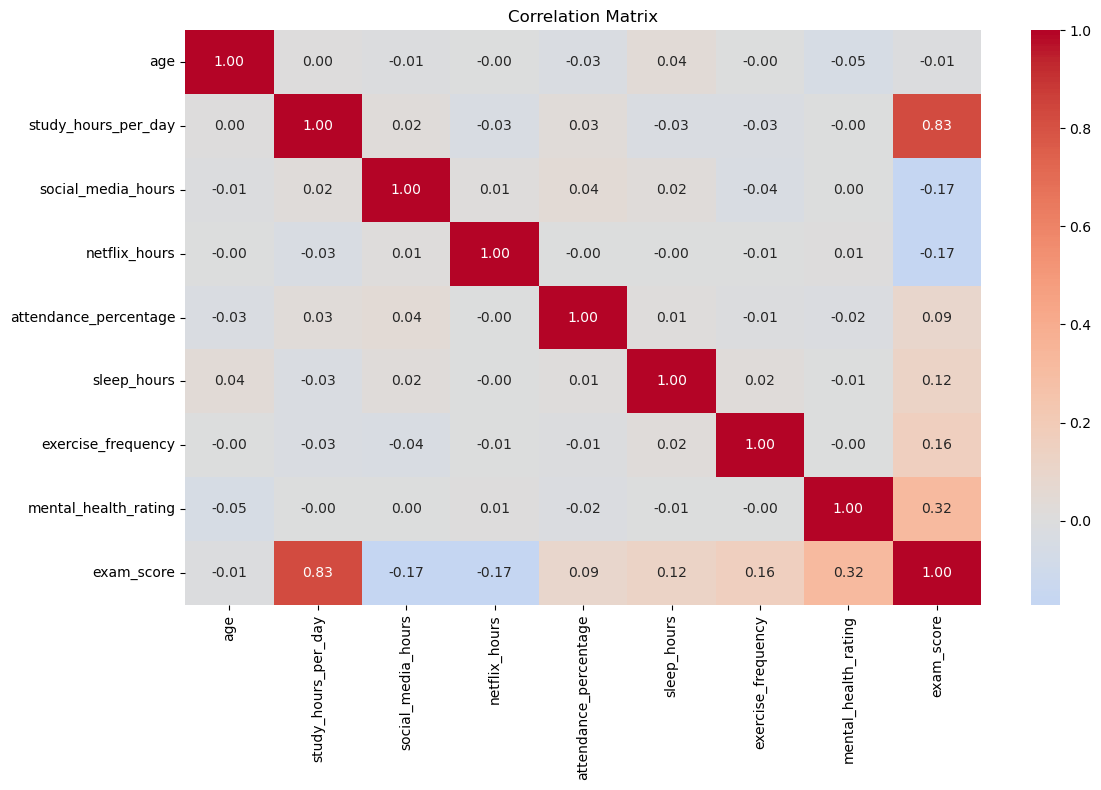

In [20]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

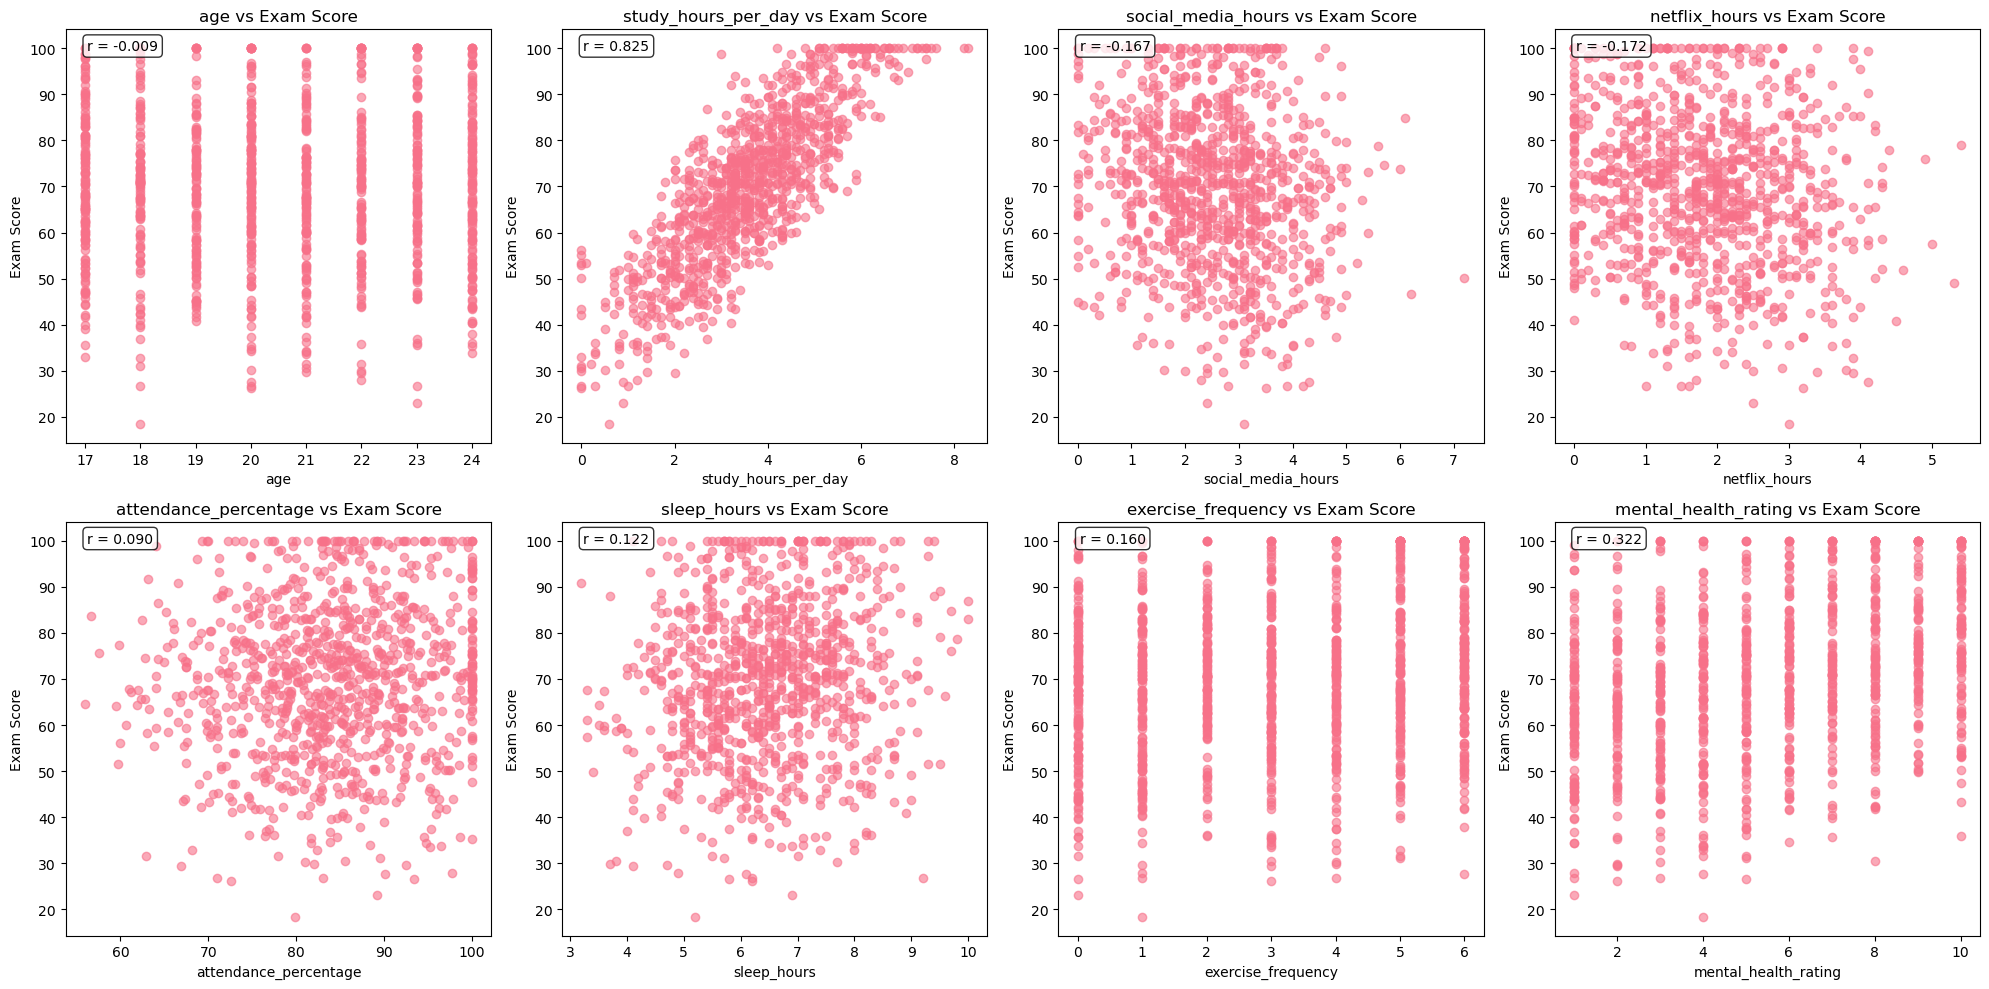

In [21]:
# Scatter plots with correlation coefficients
numerical_features = [col for col in numerical_cols if col != 'exam_score']
n_features = len(numerical_features)
cols = 4
rows = (n_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
if rows == 1:
    axes = [axes]
axes = [ax for row in axes for ax in (row if isinstance(row, np.ndarray) else [row])]

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        axes[i].scatter(df[feature], df['exam_score'], alpha=0.6)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Exam Score')
        axes[i].set_title(f'{feature} vs Exam Score')
        
        # Add correlation coefficient
        corr = df[feature].corr(df['exam_score'])
        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide unused subplots
for i in range(len(numerical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

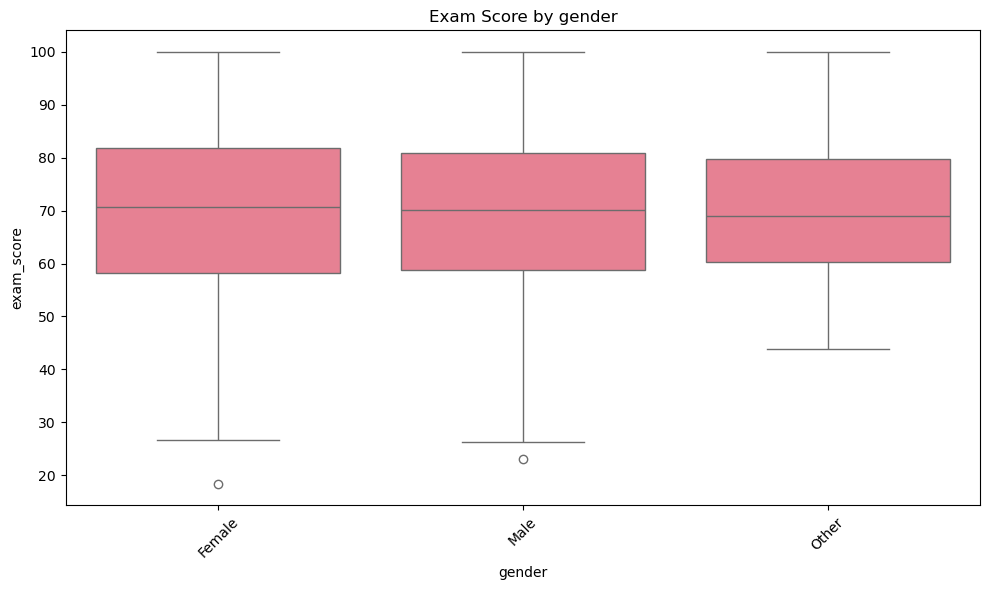

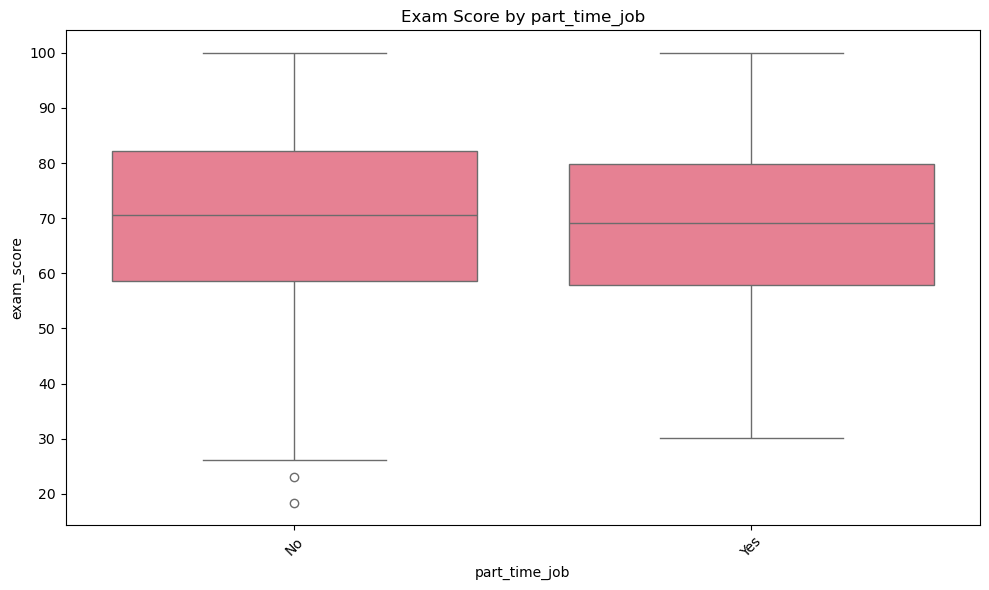

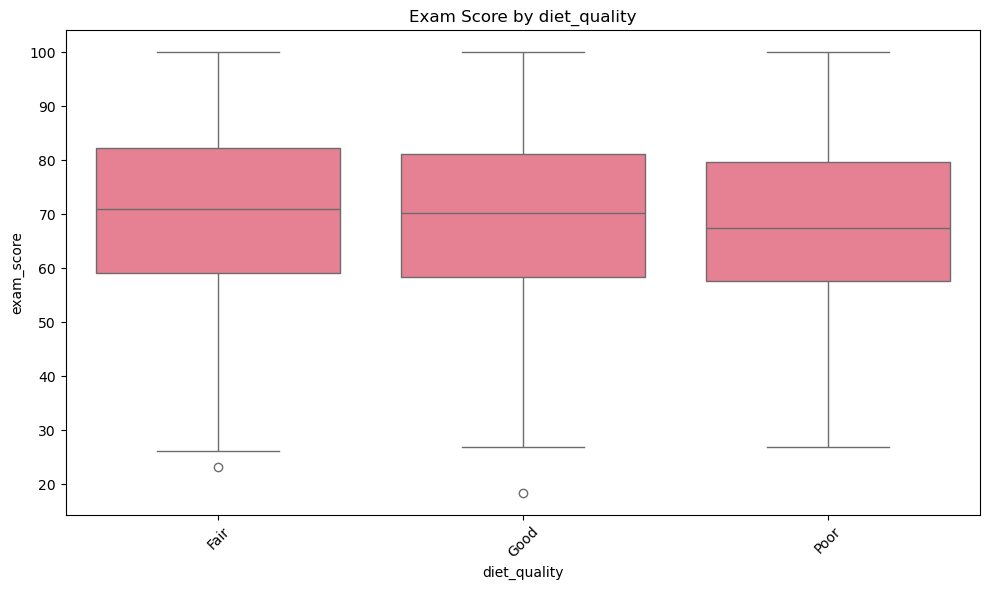

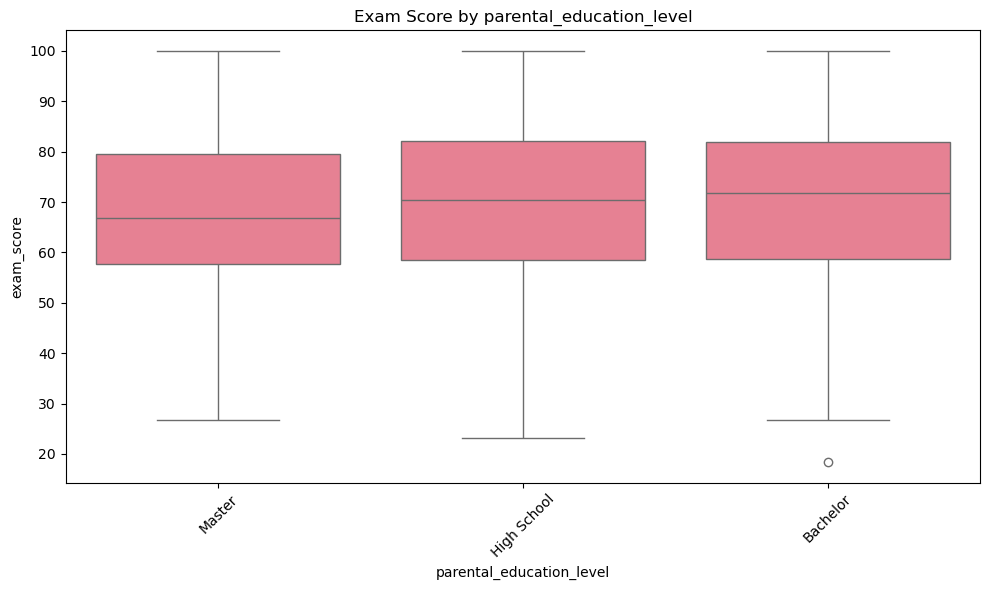

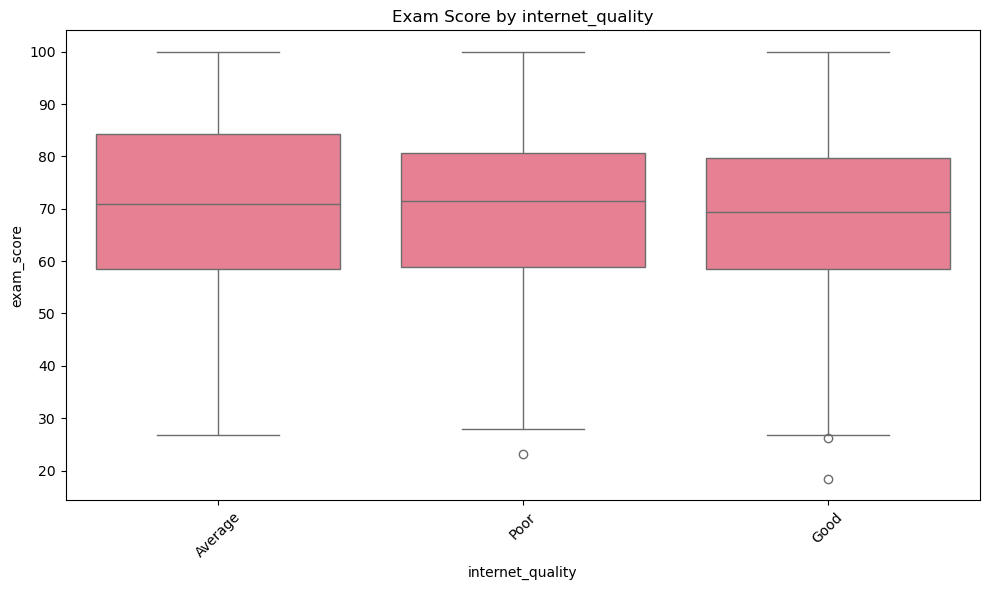

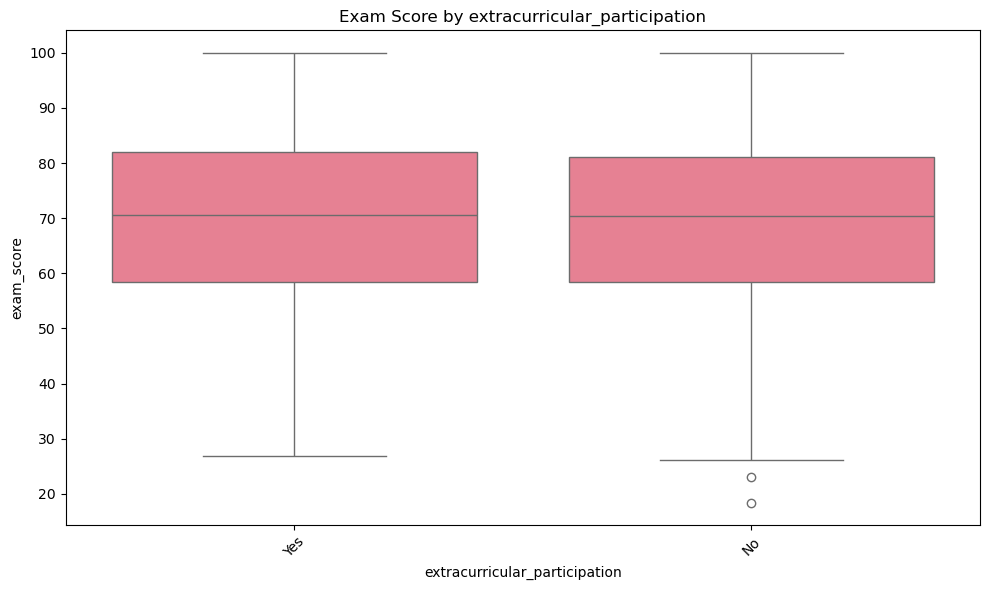

In [22]:
# Categorical analysis
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col, y='exam_score')
    plt.title(f'Exam Score by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 4. FEATURE ENGINEERING 

In [23]:
# Create new meaningful features
df['total_screen_time'] = df['social_media_hours'] + df['netflix_hours']
df['study_to_screen_ratio'] = df['study_hours_per_day'] / (df['total_screen_time'] + 0.1)  # +0.1 to avoid division by zero
df['sleep_deficit'] = np.abs(df['sleep_hours'] - 8)  

print("New features created:")
print("- total_screen_time: social_media_hours + netflix_hours")
print("- study_to_screen_ratio: study_hours_per_day / total_screen_time")
print("- sleep_deficit: deviation from 8 hours of sleep")

New features created:
- total_screen_time: social_media_hours + netflix_hours
- study_to_screen_ratio: study_hours_per_day / total_screen_time
- sleep_deficit: deviation from 8 hours of sleep


In [24]:
# Check correlations of new features
new_features = ['total_screen_time', 'study_to_screen_ratio', 'sleep_deficit']
print("\nNew feature correlations with exam_score:")
for feature in new_features:
    corr = df[feature].corr(df['exam_score'])
    print(f"{feature}: {corr:.3f}")


New feature correlations with exam_score:
total_screen_time: -0.238
study_to_screen_ratio: 0.501
sleep_deficit: -0.120


In [25]:
# Encode categorical variables with tracking
label_encoders = {}
print("\nEncoding categorical variables:")
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
    # Show encoding mapping
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col}: {mapping}")


Encoding categorical variables:
gender: {'Female': 0, 'Male': 1, 'Other': 2}
part_time_job: {'No': 0, 'Yes': 1}
diet_quality: {'Fair': 0, 'Good': 1, 'Poor': 2}
parental_education_level: {'Bachelor': 0, 'High School': 1, 'Master': 2}
internet_quality: {'Average': 0, 'Good': 1, 'Poor': 2}
extracurricular_participation: {'No': 0, 'Yes': 1}


In [26]:
# Select features for modeling
feature_columns = [
    'study_hours_per_day', 'attendance_percentage', 'mental_health_rating', 
    'sleep_hours', 'total_screen_time', 'study_to_screen_ratio', 'sleep_deficit',
    'part_time_job_encoded', 'diet_quality_encoded', 'gender_encoded'
]

In [27]:
# Prepare modeling dataset
X = df[feature_columns]
y = df['exam_score']

print(f"\nFinal feature set: {feature_columns}")
print(f"Dataset shape for modeling: X={X.shape}, y={y.shape}")


Final feature set: ['study_hours_per_day', 'attendance_percentage', 'mental_health_rating', 'sleep_hours', 'total_screen_time', 'study_to_screen_ratio', 'sleep_deficit', 'part_time_job_encoded', 'diet_quality_encoded', 'gender_encoded']
Dataset shape for modeling: X=(1000, 10), y=(1000,)


## 5. DATA PREPARATION FOR MODELING

In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Training set: 800 samples
Test set: 200 samples
Features: 10


## 6. MODEL TRAINING AND EVALUATION 

In [31]:
# Define models with hyperparameters
models_config = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {"alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {"alpha": [0.1, 1.0, 10.0]}
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {"max_depth": [3, 5, 10], "min_samples_split": [2, 5]}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"n_estimators": [50, 100], "max_depth": [5, 10]}
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {"n_estimators": [50, 100], "learning_rate": [0.1, 0.05]}
    }
}

In [32]:
# Train and evaluate each model
results = []

for name, config in models_config.items():
    print(f"\nTraining {name}...")
    
    if config["params"]:
        # Use GridSearchCV for hyperparameter tuning
        grid = GridSearchCV(
            config["model"], 
            config["params"], 
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        print(f"  Best params: {grid.best_params_}")
    else:
        # Train model directly
        best_model = config["model"]
        best_model.fit(X_train_scaled, y_train)


Training Linear Regression...

Training Ridge Regression...
  Best params: {'alpha': 0.1}

Training Lasso Regression...
  Best params: {'alpha': 0.1}

Training Decision Tree...
  Best params: {'max_depth': 5, 'min_samples_split': 2}

Training Random Forest...
  Best params: {'max_depth': 10, 'n_estimators': 50}

Training Gradient Boosting...
  Best params: {'learning_rate': 0.1, 'n_estimators': 100}


In [35]:
# Make predictions
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

In [36]:
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

In [37]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())

In [38]:
results.append({
    "Model": name,
    "Train_RMSE": train_rmse,
    "Test_RMSE": test_rmse,
    "CV_RMSE": cv_rmse,
    "Train_R2": train_r2,
    "Test_R2": test_r2,
    "Test_MAE": test_mae,
    "Fitted_Model": best_model
})
    
print(f"  Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")

  Test RMSE: 6.853, Test R²: 0.817


## 7. RESULTS ANALYSIS

In [39]:
# Create results DataFrame
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Fitted_Model'} for r in results])
results_df_sorted = results_df.sort_values('Test_RMSE')

print("\nModel Performance Summary (sorted by Test RMSE):")
print(results_df_sorted.round(3))


Model Performance Summary (sorted by Test RMSE):
               Model  Train_RMSE  Test_RMSE  CV_RMSE  Train_R2  Test_R2  \
0  Gradient Boosting       4.453      6.853    6.555     0.932    0.817   

   Test_MAE  
0     5.545  


In [41]:
# RMSE comparison
axes[0].bar(results_df['Model'], results_df['Test_RMSE'])
axes[0].set_title('Test RMSE by Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('RMSE')

Text(4.444444444444452, 0.5, 'RMSE')

In [42]:
# R² comparison
axes[1].bar(results_df['Model'], results_df['Test_R2'])
axes[1].set_title('Test R² by Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel('R²')

Text(496.7973856209152, 0.5, 'R²')

In [43]:
# Train vs Test RMSE
x = np.arange(len(results_df))
width = 0.35
axes[2].bar(x - width/2, results_df['Train_RMSE'], width, label='Train RMSE')
axes[2].bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE')
axes[2].set_title('Train vs Test RMSE')
axes[2].set_xticks(x)
axes[2].set_xticklabels(results_df['Model'], rotation=45)
axes[2].legend()
axes[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

## 8. FEATURE IMPORTANCE ANALYSIS


Feature Importance (Gradient Boosting):
                 Feature  Importance
0    study_hours_per_day    0.525394
5  study_to_screen_ratio    0.295808
2   mental_health_rating    0.117793
3            sleep_hours    0.028865
1  attendance_percentage    0.016204
6          sleep_deficit    0.007497
4      total_screen_time    0.006672
8   diet_quality_encoded    0.001079
9         gender_encoded    0.000389
7  part_time_job_encoded    0.000299


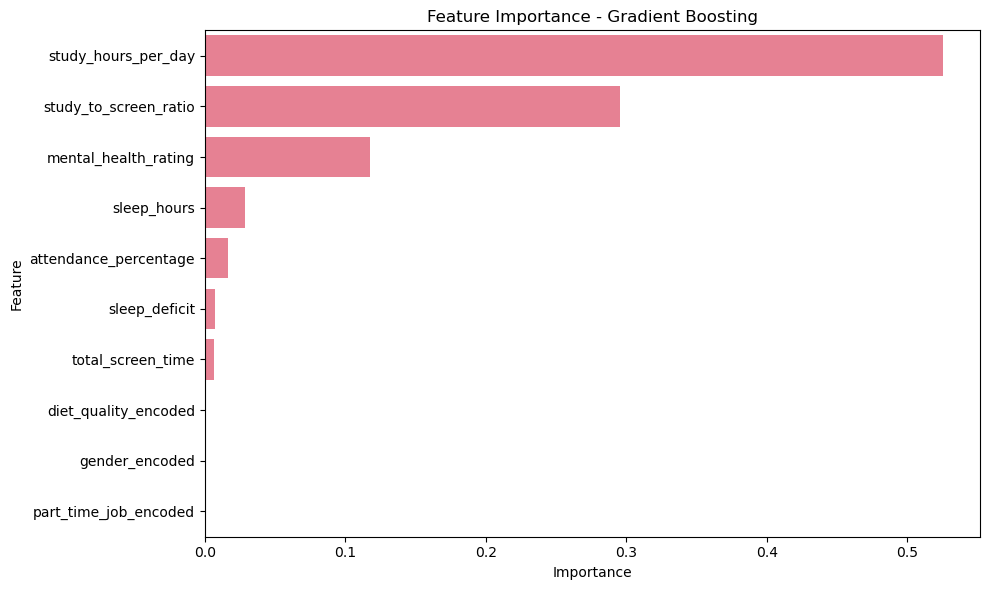

In [44]:
# Find best tree-based model for feature importance
best_tree_model = None
best_tree_name = None
for result in results:
    if result['Model'] in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
        if hasattr(result['Fitted_Model'], 'feature_importances_'):
            if best_tree_model is None or result['Test_RMSE'] < best_tree_model['Test_RMSE']:
                best_tree_model = result
                best_tree_name = result['Model']

if best_tree_model:
    importances = best_tree_model['Fitted_Model'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature Importance ({best_tree_name}):")
    print(feature_importance_df)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.title(f'Feature Importance - {best_tree_name}')
    plt.tight_layout()
    plt.show()

## 9. SAVE BEST MODEL

In [45]:
# Find best model
best_result = min(results, key=lambda x: x['Test_RMSE'])
best_model = best_result['Fitted_Model']

print(f"Best model: {best_result['Model']}")
print(f"Test RMSE: {best_result['Test_RMSE']:.3f}")
print(f"Test R²: {best_result['Test_R2']:.3f}")
print(f"Test MAE: {best_result['Test_MAE']:.3f}")

Best model: Gradient Boosting
Test RMSE: 6.853
Test R²: 0.817
Test MAE: 5.545


In [47]:
# Save complete model package
model_package = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'performance': {
        'test_rmse': best_result['Test_RMSE'],
        'test_r2': best_result['Test_R2'],
        'test_mae': best_result['Test_MAE']
    }
}

joblib.dump(model_package, 'best_exam_score_model.pkl')
print("\nModel package saved as 'best_exam_score_model.pkl'")

print(f"Best performing model: {best_result['Model']}")
print(f"Performance: RMSE = {best_result['Test_RMSE']:.3f}, R² = {best_result['Test_R2']:.3f}")


Model package saved as 'best_exam_score_model.pkl'
Best performing model: Gradient Boosting
Performance: RMSE = 6.853, R² = 0.817
